## Lab 9: Predicting Forest Cover Type with SVMs

### Introduction
In this lab, we will explore the application of Support Vector Machines (SVMs) and Random Forests (RFs) for multi-class classification using cartographic variables. Specifically, we will predict forest cover type based on a variety of environmental features such as elevation, soil type, and land aspect.

Understanding forest cover classification is crucial for natural resource management. Land managers and conservationists rely on accurate predictions of vegetation types to make informed decisions about wildlife habitats, fire management, and sustainable forestry practices. However, direct field assessments of forest cover can be costly and time-consuming, making predictive models a valuable tool for estimating cover types in large or inaccessible regions.

Dataset info here: https://archive.ics.uci.edu/dataset/31/covertype


### Step 0: Load Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("/courses/EDS232/Data/covtype_sample.csv")

In [2]:
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Rawah,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,3136,228,7,810,-7,6329,210,247,174,1307,...,0,0,0,0,0,0,0,0,0,2
1,2898,129,12,201,4,853,240,233,121,2550,...,1,0,0,0,0,0,0,0,0,2
2,2765,74,16,268,134,2850,237,208,98,6452,...,0,0,0,0,0,0,0,0,0,2
3,3078,189,10,582,-39,2554,221,247,160,1463,...,0,0,0,0,0,0,0,0,0,2
4,3141,159,11,466,-33,1080,231,242,141,1120,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2815,63,13,182,51,1707,231,214,113,1308,...,0,0,0,0,0,0,0,0,0,2
9996,3540,123,19,330,106,2680,248,222,95,2171,...,0,0,0,0,0,0,0,0,1,1
9997,2885,23,17,351,66,1595,208,202,127,2837,...,0,1,0,0,0,0,0,0,0,2
9998,3011,171,10,579,95,5700,227,245,150,3323,...,0,0,0,0,0,0,0,0,0,2


### Step 1: Data Preprocessing 

Before building our classification models, we need to prepare the dataset by separating the features target variable (`Cover_Type`) and  splitting the data into training and test sets. 

We didn't explicitly discuss it in lecture, but SVMs are sensitive to feature scale.  Use `describe()` to summarize the dataset.  Do you see anything that would require scaling of the data?  If so, apply that transformation.

In [3]:
# ---- Data preprocessing ----
pd.set_option("display.max.columns", None)

# ---- Define target variable ----
y = df['Cover_Type']
X = df.drop('Cover_Type',
            axis = 1)

In [4]:
print(X.describe())

          Elevation        Aspect         Slope  \
count  10000.000000  10000.000000  10000.000000   
mean    2955.599500    154.450000     14.114700   
std      281.786673    111.851861      7.499705   
min     1860.000000      0.000000      0.000000   
25%     2804.750000     58.000000      9.000000   
50%     2995.000000    126.000000     13.000000   
75%     3159.000000    258.000000     18.000000   
max     3846.000000    359.000000     65.000000   

       Horizontal_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      10000.000000                     10000.000000   
mean                         268.097600                        45.755300   
std                          211.899673                        58.034207   
min                            0.000000                      -164.000000   
25%                           95.000000                         7.000000   
50%                          218.000000                        29.000000   
75%     

In [5]:
# ---- Scale Data ----

# Initialize scaler
scaler = StandardScaler()

columns_to_scale = X.columns

X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

In [6]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 808)

### Step 2: Hyperparameter Tuning for SVM
To optimize our SVM model, we need to search for the best hyperparameters that maximize classification accuracy. Since SVM performance depends heavily on `C`, `kernel`, and `gamma`, we will use `GridSearchCV()` to systematically test different combinations. Initialize a cross validation object with 5 folds using `StratifiedKFold`. Check out how `StratifiedKFold` differs from `Kfold` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html). 

Then, set up a grid to test different values of: 
- `C` (regularization strength): how strictly the model fits the training data
  - Candidate parameter values: `(0.1, 1, 10, 100)`
- `kernel` (decision boundary shape): compares linear and radial basis function shapes
  - Candidate parameter values: (linear, rbf)
- `gamma` (influence of training observations): influence of individual points on decision boundary
  - Candidate parameter values: (scale, auto)

As models and datasets become more complex, consideration of computation time becomes more important.  You'll use `time.time()` to measure the time required to fit the grid object.  

**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [7]:
# Define hyperparameters for svm
param_grid_svm = { 'C': [0.1,1,10,100],
                 'kernel': ['linear','rbf'],
                 'gamma': ['scale','auto']}


# Initalize SVM classifier
svm = SVC(random_state = 808)

# Initialize Statified Kfold
kfold = StratifiedKFold(n_splits = 5) # should I shuffle


# Initialize Grid Search
grid_search_svm = GridSearchCV(svm,
                               param_grid_svm,
                               cv = kfold,
                               n_jobs = 5,
                               verbose = 0)
    

In [8]:
# Record SVM start time
start_time_svm = time.time()

# Fit SVM grid search
grid_search_svm.fit(X_train, y_train)

# Record SVM end time
end_time_svm = time.time()

In [9]:
# Calculate elapsed time for SVM grid search
elapsed_time_svm = end_time_svm - start_time_svm
print("Elapsed time for svm grid search:", elapsed_time_svm)

Elapsed time for svm grid search: 1137.2858402729034


In [10]:
# Best SVM model
best_svm = grid_search_svm.best_estimator_
y_train_pred_svm = best_svm.predict(X_train)
y_test_pred_svm = best_svm.predict(X_test)

print("The best params for SVM are:", grid_search_svm.best_params_)

The best params for SVM are: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


### Step 3: Build a fit a Random Forest for comparison

Let's compare our SVM to a Random Forest classifier.  Create a grid for cross-validation with three hyperparameters of your choice to tune, along with three sensible values for each one.  
**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [11]:
# Define hyperparameter for rf
param_grid_rf = {
    "n_estimators":[100, 500, 1000],
    "max_features":["sqrt", 10, None],
    "max_depth":[4,6],
    "min_samples_split":[2,6]
}


# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state = 808)

# Initialize Grid Search
grid_search_rf = GridSearchCV(rf,
                     param_grid_rf,
                     cv = kfold,
                     n_jobs = 5,
                     verbose = 0)

In [12]:
# Record RF start time
start_time_rf = time.time()

# Fit RF grid search
grid_search_rf.fit(X_train, y_train)

# Record RF end time
end_time_rf = time.time()

In [13]:
# Calculate elapsed time for RF grid search
elapsed_time_rf = end_time_rf - start_time_rf
print("Elapsed time for rf grid search:", elapsed_time_rf)

Elapsed time for rf grid search: 133.23404383659363


In [14]:
# Best SVM model
best_rf = grid_search_rf.best_estimator_
y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf = best_rf.predict(X_test)
print("The best params for RF are:", grid_search_rf.best_params_)

The best params for RF are: {'max_depth': 6, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 100}


### Step 4: Model Predictions and Evaluation
Now that you have trained and optimized both a SVM and RF model, you will evaluate their performances on the test set to prepare for model comparison. In this step, you will:
- Use the best models from `GridSearchCV()` to make predictions on the test set
- Generate a confusion matrix for each model to visualize classification performance


In [15]:
# Initalize SVM model with best params
svm_best_params = SVC(**grid_search_svm.best_params_,
                      random_state = 808)

# Train SVM model
svm_best_params.fit(X_train, y_train)

# Generate SVM test predictions
svm_best_pred = svm_best_params.predict(X_test)

In [16]:
# Initalize rf model with best params
rf_best_params = RandomForestClassifier(**grid_search_rf.best_params_,
                      random_state = 808)

# Train rf model
rf_best_params.fit(X_train, y_train)

# Generate rf test predictions
rf_best_pred = rf_best_params.predict(X_test)

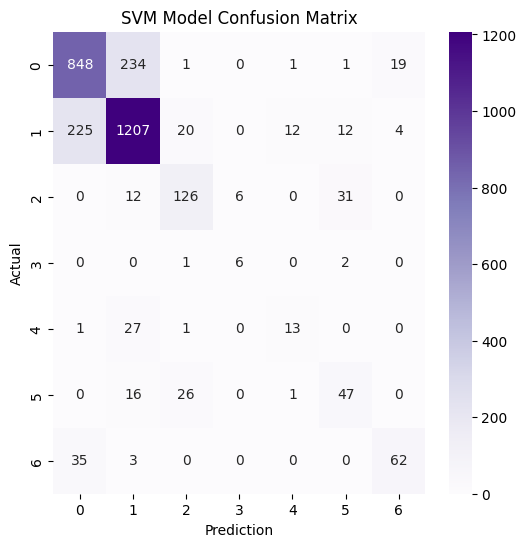

In [17]:
# Create SVM confusion matrix
svm_matrix = confusion_matrix(y_test, svm_best_pred)

# Plot SVM confusion matrix
plt.figure(figsize = (6,6))
sns.heatmap(svm_matrix,
            fmt = 'd',
            cmap = 'Purples',
            annot = True)
plt.title('SVM Model Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Prediction')


plt.show()

Text(0.5, 36.72222222222221, 'Prediction')

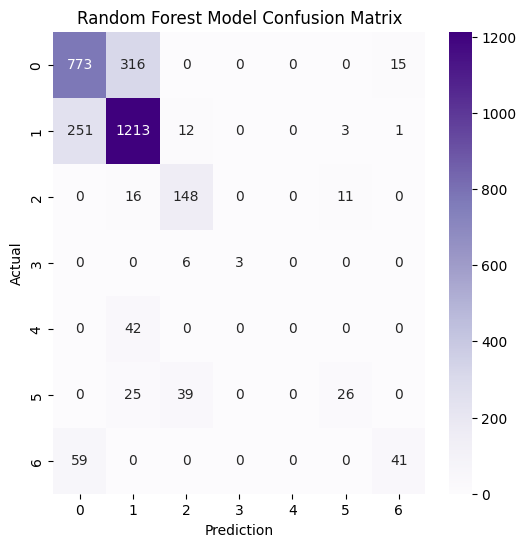

In [18]:
# Create RF confusino matrix
rf_matrix = confusion_matrix(y_test, rf_best_pred)

# Plot RF confusion matrix
plt.figure(figsize = (6,6))
sns.heatmap(rf_matrix,
            fmt = 'd',
            cmap = 'Purples',
            annot = True)
plt.title('Random Forest Model Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Prediction')

### Step 5: Gather and display additional performance metrics
Now display the accuracy score and training time required for each model to so we can compare the models.

In [19]:
# Display additional performance metrics
print(f"SVM accuracy score: {accuracy_score(y_test, svm_best_pred):.3f}")
      
print(f"SVM training time: {elapsed_time_svm:.2f} seconds")
      
      
print(f"RF accuracy: {accuracy_score(y_test, rf_best_pred):.3f}")
print(f"RF training time: {elapsed_time_rf:.2f} seconds")

SVM accuracy score: 0.770
SVM training time: 1137.29 seconds
RF accuracy: 0.735
RF training time: 133.23 seconds


### Step 6: Compare the models
Now that we have trained, optimized, and evaluated both SVM and RF models, we will compare them based on overall accuracy, training time, and types of errors made.

Based on these comparisons, which model is more suitable for this task?  


Based on my results, the SWM model performed better than the RF model. The accuracy score for the SWM was .77 verses .73 for the RF model. In addition to having a better accuracy score, the SWM model performed better across all predictor variables in the confusion matrix. The SWM model was also significantly more computationally intensive, it took over 18 minutes to run while the Random Forest ran in just over 2 minutes. Even with the longer computation time, I think that 18 minutes is a reasonable cost for the added accuracy and ability for the SWM model to perform better across all of the predictor variables makes it a more suitable model for this task.